In [1]:
import torchvision
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import onnx
from onnxsim import simplify

In [2]:
from PIL import Image

# open method used to open different extension image file
im = Image.open(r"../data/images/crypko_00.png")
array = np.array(im)
im = torch.from_numpy(array).unsqueeze(0)
angle = torch.tensor([-5])       # 旋转 30 度
translate = torch.tensor([-50, 50])  # 向右 50 像素，向下 20 像素
scale = 1      # 缩小到 80%

In [3]:
import torch
import torch.nn as nn

# https://pytorch.org/docs/stable/generated/torch.nn.functional.affine_grid.html
# https://github.com/pytorch/pytorch/blob/master/aten/src/ATen/native/AffineGridGenerator.cpp
def affine_grid(theta, size, align_corners=False):
    N, C, H, W = size
    grid = create_grid(N, C, H, W)
    grid = grid.view(N, H * W, 3).bmm(theta.transpose(1, 2))
    grid = grid.view(N, H, W, 2)
    return grid

def create_grid(N, C, H, W):
    grid = torch.empty((N, H, W, 3), dtype=torch.float32)
    grid.select(-1, 0).copy_(linspace_from_neg_one(W))
    grid.select(-1, 1).copy_(linspace_from_neg_one(H).unsqueeze_(-1))
    grid.select(-1, 2).fill_(1)
    return grid
    
def linspace_from_neg_one(num_steps, dtype=torch.float32):
    r = torch.linspace(-1, 1, num_steps, dtype=torch.float32)
    r = r * (num_steps - 1) / num_steps
    return r

def patch_affine_grid_generator():
    torch.nn.functional.affine_grid = affine_grid

class AffineTransform(nn.Module):
    def __init__(self):
        super().__init__()
        self.identity_matrix = torch.eye(3)

    def forward(self, image, angle, translate, scale):
        """
        Args:
            image: torch.Tensor (N, H, W, C) uint8
            angle: float 旋转角度（度）
            translate: tuple (tx, ty) 像素单位的平移
            scale: float 缩放因子
        Returns:
            torch.Tensor (N, H, W, C) uint8
        """
        # 转换为float32并归一化到[0, 1]
        x = image.float() / 255.0
        
        # 转换到NCHW布局
        x = x.permute(0, 3, 1, 2)
        
        # 生成仿射矩阵
        theta = self._get_affine_matrix(x.size(), angle, translate, scale)
        
        # 创建采样网格
        grid = affine_grid(theta, x.size(), align_corners=True)
        
        # 应用仿射变换
        x = nn.functional.grid_sample(
            x, 
            grid,
            mode='bilinear',
            padding_mode='zeros',
            align_corners=True
        )
        
        # 转换回NHWC布局
        x = x.permute(0, 2, 3, 1)
        
        # 转换回uint8
        return (x.clamp(0, 1) * 255).type(torch.uint8)

    def _get_affine_matrix(self, size, angle, translate, scale):
        N, _, H, W = size

        # 转换为齐次坐标的3x3矩阵
        def create_3x3_matrix(batch_size):
            return self.identity_matrix.unsqueeze(0).repeat(batch_size, 1, 1)

        # 缩放矩阵
        scale_matrix = create_3x3_matrix(N)
        scale_matrix[:, 0, 0] = scale
        scale_matrix[:, 1, 1] = scale

        # 旋转矩阵
        angle_rad = angle * torch.pi / 180.0
        cos = torch.cos(angle_rad)
        sin = torch.sin(angle_rad)
        rotation_matrix = create_3x3_matrix(N)
        rotation_matrix[:, 0, 0] = cos
        rotation_matrix[:, 0, 1] = -sin
        rotation_matrix[:, 1, 0] = sin
        rotation_matrix[:, 1, 1] = cos

        # 平移矩阵（考虑坐标系转换）
        tx, ty = translate
        translate_matrix = create_3x3_matrix(N)
        translate_matrix[:, 0, 2] = 2.0 * tx / (W - 1)  # 转换到PyTorch坐标系
        translate_matrix[:, 1, 2] = 2.0 * ty / (H - 1)

        # 组合变换矩阵：Translate @ Rotate @ Scale
        # 注意矩阵乘法顺序（从右到左应用变换）
        matrix = translate_matrix @ rotation_matrix @ scale_matrix

        # 提取前两行形成2x3矩阵（PyTorch要求的格式）
        return matrix[:, :2, :]


In [4]:
affine = AffineTransform()
transformed_img = affine(im, angle, translate, scale)

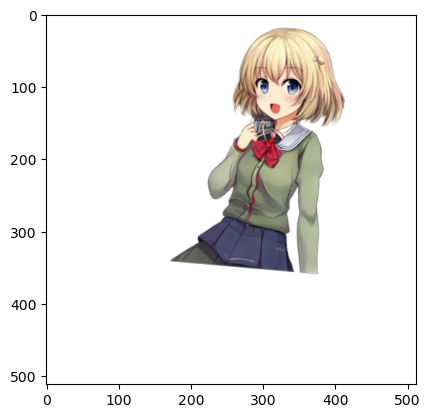

In [5]:
plt.imshow(np.array(transformed_img.squeeze(0)))
plt.show()

In [6]:
# 导出参数
onnx_path = "model_static.onnx"
input_names = ["img", 'angle', 'translate','scale']    # 输入节点名称
output_names = ["output"] # 输出节点名称

# 执行导出
torch.onnx.export(
    affine,
    (torch.randn(1,512,512,4).to(torch.uint8),  torch.randn((1,),dtype= torch.float32), torch.randn((2,),dtype= torch.float32),torch.randn((1,),dtype= torch.float32) ),
    onnx_path,
    input_names=input_names,
    output_names=output_names,
    opset_version=16,     # 推荐使用 opset 11+ 以获得更好兼容性
    do_constant_folding=True,  # 优化常量折叠
    verbose=False         # 不打印详细信息
)
onnx_model = onnx.load(onnx_path)
onnx.checker.check_model(onnx_model)
onnx_model_sim, check = simplify(onnx_model)
if check:
    onnx.save(onnx_model_sim, 'affine_512.onnx')
else:
    raise ValueError("Simplify error")


# 执行导出
torch.onnx.export(
    affine,
    (torch.randn(1,1024,1024,4).to(torch.uint8),  torch.randn((1,),dtype= torch.float32), torch.randn((2,),dtype= torch.float32),torch.randn((1,),dtype= torch.float32) ),
    onnx_path,
    input_names=input_names,
    output_names=output_names,
    opset_version=16,     # 推荐使用 opset 11+ 以获得更好兼容性
    do_constant_folding=True,  # 优化常量折叠
    verbose=False         # 不打印详细信息
)
onnx_model = onnx.load(onnx_path)
onnx.checker.check_model(onnx_model)
onnx_model_sim, check = simplify(onnx_model)
if check:
    onnx.save(onnx_model_sim, 'affine_1024.onnx')
else:
    raise ValueError("Simplify error")

C:\Users\a2843\AppData\Local\Temp\ipykernel_12300\494384424.py:93: TracerWarning: Iterating over a tensor might cause the trace to be incorrect. Passing a tensor of different shape won't change the number of iterations executed (and might lead to errors or silently give incorrect results).
  tx, ty = translate
F:\Anaconda\envs\talking-head-anime-3-dev\lib\site-packages\torch\onnx\utils.py:668: UserWarning: ONNX Preprocess - Removing mutation from node aten::copy_ on block input: 'scale'. This changes graph semantics. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\jit\passes\onnx\remove_inplace_ops_for_onnx.cpp:355.)
  _C._jit_pass_onnx_remove_inplace_ops_for_onnx(graph, module)


In [7]:
import argparse
from pathlib import Path
import sys
import os
import numpy as np
import tensorrt as trt
from typing import List, Tuple
import pycuda.driver as cuda
import pycuda
from os.path import join
import numpy
import pycuda.autoinit
TRT_LOGGER = trt.Logger(trt.Logger.INFO)
def build_engine(onnx_file_path, precision:str):
    builder = trt.Builder(TRT_LOGGER)
    network = builder.create_network()
    config = builder.create_builder_config()
    parser = trt.OnnxParser(network, TRT_LOGGER)
    # Parse model file
    TRT_LOGGER.log(TRT_LOGGER.INFO, f'Loading ONNX file from path {onnx_file_path}...')
    with open(onnx_file_path, 'rb') as model:
        TRT_LOGGER.log(TRT_LOGGER.INFO, 'Beginning ONNX file parsing')
        parse_res = parser.parse(model.read())
        if not parse_res:
            for error in range(parser.num_errors):
                TRT_LOGGER.log(TRT_LOGGER.ERROR, parser.get_error(error))
            raise ValueError('Failed to parse the ONNX file.')
    TRT_LOGGER.log(TRT_LOGGER.INFO, 'Completed parsing of ONNX file')
    TRT_LOGGER.log(TRT_LOGGER.INFO, f'Input number: {network.num_inputs}')
    TRT_LOGGER.log(TRT_LOGGER.INFO, f'Output number: {network.num_outputs}')
    def GiB(val):
        return val * 1 << 30
    config.set_memory_pool_limit(trt.MemoryPoolType.WORKSPACE, GiB(1)) # 1G
    

    if precision == 'fp32':
        config.set_flag(trt.BuilderFlag.TF32)
    elif precision == 'fp16':
        config.set_flag(trt.BuilderFlag.FP16)
    else:
        raise ValueError('precision must be one of fp32 or fp16')
    
    TRT_LOGGER.log(TRT_LOGGER.INFO, f'Building an engine from file {onnx_file_path}; this may take a while...')
    serialized_engine = builder.build_serialized_network(network, config)
    TRT_LOGGER.log(TRT_LOGGER.INFO, 'Completed creating Engine')
    return serialized_engine

def save_engine(engine, path):
    TRT_LOGGER.log(TRT_LOGGER.INFO, f'Saving engine to file {path}')
    path = Path(path)
    path.parent.mkdir(parents=True, exist_ok=True)
    with open(path, 'wb') as f:
        f.write(engine)
    TRT_LOGGER.log(TRT_LOGGER.INFO, 'Completed saving engine')
def load_engine(path):
    TRT_LOGGER.log(TRT_LOGGER.WARNING, f'Loading engine from file {path}')
    runtime = trt.Runtime(TRT_LOGGER)
    with open(path, 'rb') as f:
        engine = runtime.deserialize_cuda_engine(f.read())
    TRT_LOGGER.log(TRT_LOGGER.INFO, 'Completed loading engine')
    return engine

#memory management
class HostDeviceMem(object):
    def __init__(self, host_mem:numpy.ndarray, device_mem: pycuda.driver.DeviceAllocation):
        self.host = host_mem
        self.device = device_mem

    def __str__(self):
        return "Host:\n" + str(self.host) + "\nDevice:\n" + str(self.device)

    def __repr__(self):
        return self.__str__()
    def __del__(self):
        self.device.free()
    def dtoh(self, stream:pycuda.driver.Stream):
        cuda.memcpy_dtoh_async(self.host, self.device, stream) 
    def htod(self, stream:pycuda.driver.Stream):
        cuda.memcpy_htod_async(self.device, self.host, stream)

class Processor:
    def __init__(self, engine: trt.ICudaEngine, n_input:int):
        self.engine = engine
        TRT_LOGGER.log(TRT_LOGGER.INFO, 'Creating inference context')
        # create execution context
        self.context = engine.create_execution_context()
        
        # get input and output tensor names
        self.input_tensor_names = [engine.get_tensor_name(i) for i in range(n_input)]
        self.output_tensor_names = [engine.get_tensor_name(i) for i in range(n_input, self.engine.num_io_tensors)]
        TRT_LOGGER.log(TRT_LOGGER.INFO, 'Input nodes: '+ str(self.input_tensor_names))
        TRT_LOGGER.log(TRT_LOGGER.INFO, 'Output nodes: '+ str(self.output_tensor_names))
        #create memories and bindings
        self.inputs = []
        self.outputs = []
        for bindingName in engine:
            shape = [dim for dim in self.context.get_tensor_shape(bindingName)]
            dtype = trt.nptype(engine.get_tensor_dtype(bindingName))
            host_mem = cuda.pagelocked_empty(shape, dtype)
            device_mem = cuda.mem_alloc(host_mem.nbytes)
            mem = HostDeviceMem(host_mem, device_mem)
            self.context.set_tensor_address(bindingName, int(device_mem)) # Use this setup without binding for v3
            if bindingName in self.input_tensor_names:
                self.inputs.append(mem)
            else:
                self.outputs.append(mem)

        # create stream
        self.stream = cuda.Stream()
        # Create a CUDA events
        self.start_event = cuda.Event()
        self.end_event = cuda.Event()

            
    def get_last_inference_time(self):
        return self.start_event.time_till(self.end_event)

    def loadInputs(self, inputs: List[np.ndarray]):
        # set input shapes, the output shapes are inferred automatically
        for inp, inp_mem in zip(inputs, self.inputs):
            if inp.dtype != inp_mem.host.dtype or inp.shape != inp_mem.host.shape:
                print('Given:', inp.dtype, inp.shape)
                print('Expected:',inp_mem.host.dtype, inp_mem.host.shape)
                raise ValueError('Input shape or type does not match')
            np.copyto(inp_mem.host, inp)
        for inp_mem in self.inputs: inp_mem.htod(self.stream)
        # Synchronize the stream
        self.stream.synchronize()

    def kickoff(self):
        # Record the start event
        self.start_event.record(self.stream)
        # Run inference.
        self.context.execute_async_v3(self.stream.handle)
        # Record the end event
        self.end_event.record(self.stream)
        # Synchronize the stream
        self.stream.synchronize()

    def extractOutputs(self, copy:bool = True) -> List[np.ndarray]:
        for out_mem in self.outputs: out_mem.dtoh(self.stream)
        # Synchronize the stream
        self.stream.synchronize()
        if copy:
            return [np.copy(outp.host) for outp in self.outputs]
        else:
            return [outp.host for outp in self.outputs]
        
        
    def inference(self, inputs: List[np.ndarray]) -> List[np.ndarray]:
        """
        inference process:
        1. create execution context
        2. set input shapes
        3. allocate memory
        4. copy input data to device
        5. run inference on device
        6. copy output data to host and reshape
        """

        # set input shapes, the output shapes are inferred automatically
        for inp, inp_mem in zip(inputs, self.inputs):
            if inp.dtype != inp_mem.host.dtype or inp.shape != inp_mem.host.shape:
                print('Given:', inp.dtype, inp.shape)
                print('Expected:',inp_mem.host.dtype, inp_mem.host.shape)
                raise ValueError('Input shape or type does not match')
            np.copyto(inp_mem.host, inp)

        for inp_mem in self.inputs: inp_mem.htod(self.stream)
            
        # Record the start event
        self.start_event.record(self.stream)
        # Run inference.
        self.context.execute_async_v3(self.stream.handle)
        # Record the end event
        self.end_event.record(self.stream)

        for out_mem in self.outputs: out_mem.dtoh(self.stream)
            
        # Synchronize the stream
        self.stream.synchronize()
        
        return [np.copy(outp.host) for outp in self.outputs]

In [8]:
save_engine(build_engine('affine_1024.onnx','fp32'),
            './affine_1024.trt')

In [9]:
p = Processor(load_engine('./affine_1024.trt'),1)

In [10]:
from tqdm import tqdm
for i in tqdm(range(10000)):
    p.kickoff()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1755.37it/s]
